In [3]:
# Library Import
import pathlib
import os
import sys
import random
import nibabel as nib
import numpy as np
import argparse
import pandas as pd
import h5py
import torch
import torch.nn as nn
import keras
import matplotlib.pyplot as plt
import time
import SimpleITK as sitk


# Functionality Import
from pathlib import Path
from math import exp
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn.functional as F
from torch.autograd import Variable
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.preprocessing import StandardScaler
from nilearn.image import load_img
from nilearn.masking import unmask
from tqdm.notebook import tqdm
from alive_progress import alive_bar
from ipywidgets import interactive, IntSlider
torch.autograd.set_detect_anomaly(True)


---

# *Reader* **Settings**

---

In [27]:
# [fcglVNN] Fixed Conditional Generative Linear Voxel Neural Network Model Parametrizations Parser Initialization
parser = argparse.ArgumentParser(
    description = "fcglVNN Model Settings")
parser.add_argument(                            # Dataset Version Variable
    '--data_version', type = int,           # Default: 0
    default = 0,
    help = "Dataset Save Version")

# Dataset General Parametrization Arguments
parser.add_argument(                            # Dataset Batch Size Value
    '--batch_size', type = int,                 # Default: 109236 (Patient 13)
    default = 136799,
    help = "Dataset Batch Size Value")
parser.add_argument(                            # Number of Workers for DataLoader Usage
    '--num_workers', type = int,                # Default: 1
    default = 12,
    help = "Number of Workers for DataLoader Usage")
parser.add_argument(                            # Ability to Shuffle the Samples inside both Training and Validation Sets
    '--sample_shuffle', type = bool,            # Default: False
    default = False,
    help = "Ability to Shuffle the Samples inside both Training and Validation Sets")
parser.add_argument(                            # Number of Training Parameters
    '--num_train_params', type = int,           # Default: 500
    default = 500,
    help = "No. of Training Parameters")

# --------------------------------------------------------------------------------------------

# Dataset Label Parametrization Arguments
parser.add_argument(                                    # Control Variable for the Inclusion of Patient ID in Labels
    '--patient_id', type = bool,                        # Default: True
    default = False,
    help = "Control Variable for the Inclusion of Patient ID in Labels")
parser.add_argument(                                    # Control Variable for the Conversion of 3 Gradient Directions
    '--gradient_coord', type = bool,                    # Coordinates into 2 Gradient Direction Angles (suggested by prof. Chantal)
    default = True,                                     # Default: True (3 Coordinate Gradient Values)
    help = "Control Variable for the Conversion of Gradient Direction Mode")
parser.add_argument(                                    # Control Variable for the Rescaling & Normalization of Labels
    '--label_norm', type = bool,                        # Default: True
    default = False,
    help = "Control Variable for the Rescaling & Normalization of Labels")
settings = parser.parse_args(""); num_labels = 7
if not(settings.patient_id): num_labels -= 1            # Exclusion of Patiend ID
if not(settings.gradient_coord): num_labels -= 1        # Conversion of Gradient Coordinates to Angles
parser.add_argument(                                    # Dataset Number of Labels
    '--num_labels', type = int,                         # Default: 7
    default = num_labels,
    help = "MUDI Dataset Number of Labels")

# --------------------------------------------------------------------------------------------

# Addition of Dataset-Related File & Folderpath Arguments
parser.add_argument(                                    # Path for Parameter Value File
    '--param_filepath', type = Path,
    default = Path('Raw Data/parameters_new.xlsx'),
    help = 'Input Filepath for Parameter Value Table')
parser.add_argument(                                    # Path for Parameter Value File
    '--data_filepath', type = Path,
    default = Path('Raw Data/data_.hdf5'),
    help = 'Input Filepath for Parameter Value Table')
parser.add_argument(                                    # Path for Patient Information File
    '--info_filepath', type = Path,
    default = Path('Raw Data/header_.csv'),
    help = 'Input Filepath for Patient Information Table')
parser.add_argument(                                    # Path for Folder Containing Patient Data Files
    '--patient_folderpath', type = Path,
    default = Path('Patient Data'),
    help = 'Input Folderpath for Segregated Patient Data')
parser.add_argument(                                    # Path for Folder Containing Mask Data Files
    '--mask_folderpath', type = Path,
    default = Path('Patient Mask'),
    help = 'Input Folderpath for Segregated Patient Mask Data')
parser.add_argument(                                    # Path for Folder Containing Ishaan's Reader Files
    '--ishaan_folderpath', type = Path,
    default = Path('Ishaan Data'),
    help = "Input Folderpath for Ishaan's Reader")
parser.add_argument(                                    # Path for Dataset Saved Files
    '--datasave_folderpath', type = Path,
    default = Path(f'Saved Data/V{settings.data_version}'),
    help = 'Output Folderpath for MUDI Dataset Saved Versions')

# --------------------------------------------------------------------------------------------

# Addition of Result Visualization Arguments
parser.add_argument(                                    # Selected Patient
    '--sel_patient', type = list,                       # Default: 11
    default = [14],
    help = "Selected Patient")
parser.add_argument(                                    # Percentage of Reconstructed Parameters during Training
    '--param_recon_train', type = int or float,         # Default: 25% | 0.2% for 1 Reconstruction
    default = 100,
    help = "Percentage of Reconstructed Parameters during Training")
parser.add_argument(                                    # Percentage of Reconstructed Parameters for Full Image Reconstruction
    '--param_recon_full', type = int or float,          # Default: 5% (20% of 25%) | 0.9% for 2 Reconstruction
    default = 5,
    help = "Percentage of Reconstructed Parameters for Full Image Reconstruction")
parser.add_argument(                                    # Ability to Shuffle the Parameters for Reconstruction
    '--param_shuffle', type = bool,                     # Default: True
    default = True,
    help = "Ability to Shuffle the Parameters for Reconstruction")

settings = parser.parse_args("")
settings.device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

---

# *Reader* **Initialization**

---

## **Original** *Reader*

*Keras with HDF5 File*

Different from the Rest due to being created for the 500->1344 Model, while the others were created for the 505->1 Model

In [ ]:
class MRISelectorSubjDataset(keras.utils.Sequence):
    """MRI dataset to select features from."""

    def __init__(self, root_dir, dataf, headerf, subj_list, batch_size=100, shuffle=False):
        """
        Args:
            root_dir (string): Directory with the .csv files
            data (string): Data .csv file
            header (string): Header .csv file
            subj_list (list): list of all the subjects to include
        """
        
        self.root_dir = root_dir
        self.dataf = dataf
        self.headerf = headerf
        self.subj_list = subj_list
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        # load the header
        subj = self.subj_list[0]
        self.header = pd.read_csv(os.path.join(self.root_dir,
                                             self.headerf), index_col=0).to_numpy()
        self.ind = self.header[np.isin(self.header[:,1],self.subj_list),0]
#         print(self.ind)
        
        self.indexes = np.arange(len(self.ind)) 

    def __len__(self):
        return int(np.ceil(len(self.ind) / float(self.batch_size)))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
#         print(indexes)

        # Find list of IDs
        list_IDs_temp = [self.ind[k] for k in indexes]
#         print(list_IDs_temp)

        # Generate data
        signals = self.__data_generation(list_IDs_temp)

        return signals, signals

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.ind)) 
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Generate data
        # X = pd.read_csv(os.path.join(self.root_dir, self.dataf), index_col=0, skiprows=lambda x: x not in list_IDs_temp).to_numpy()
        h5f = h5py.File(os.path.join(self.root_dir, self.dataf), 'r')
        X = h5f.get('data1')
        X = X[list_IDs_temp,:]

        return X

class MRIDecoderSubjDataset(keras.utils.Sequence):
    """MRI dataset to select features from."""

    def __init__(self, root_dir, dataf, headerf, subj_list, selecf, input_dim=1344, batch_size=100, shuffle=False):
        """
        Args:
            root_dir (string): Directory with the .csv files
            data (string): Data .csv file
            header (string): Header .csv file
            subj_list (list): list of all the subjects to include
        """
        
        self.root_dir = root_dir
        self.dataf = dataf
        self.headerf = headerf
        self.subj_list = subj_list
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.selecf = selecf
        
        # load the header
        subj = self.subj_list[0]
        self.header = pd.read_csv(os.path.join(self.root_dir,
                                             self.headerf), index_col=0).to_numpy()
        self.ind = self.header[np.isin(self.header[:,1],self.subj_list),0]
#         print(self.ind)
        
        self.indexes = np.arange(len(self.ind)) 
        
        # load the select file
        self.selecind = np.sort(np.loadtxt(self.selecf, dtype=int))
        #print(self.selecind)
        
        self.msk = np.logical_not(np.isin(np.arange(input_dim),self.selecind))

    def __len__(self):
        return int(np.ceil(len(self.ind) / float(self.batch_size)))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
#         print(indexes)

        # Find list of IDs
        list_IDs_temp = [self.ind[k] for k in indexes]
#        print(list_IDs_temp)

        # Generate data
        selec_signals, signals = self.__data_generation(list_IDs_temp)
        
#        print(selec_signals.shape)
#        print(signals.shape)

        return selec_signals, signals

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.ind)) 
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Generate data
        # X = pd.read_csv(os.path.join(self.root_dir, self.dataf), index_col=0, skiprows=lambda x: x not in list_IDs_temp).to_numpy()
        h5f = h5py.File(os.path.join(self.root_dir, self.dataf), 'r')
        X = h5f.get('data1')
        X = X[list_IDs_temp,:]
        X1 = X[:,self.selecind]
        # X2 = X[:,self.msk]
        return X1, X

In [ ]:
# Dataset Access
old_set = MRIDecoderSubjDataset(root_dir = 'Raw Data/', dataf = 'data_.hdf5', headerf = 'header_.csv',
                                selecf = f'{settings.datasave_folderpath}/1D Training Labels (V{settings.data_version}).txt',
                                subj_list = np.array(settings.sel_patient), batch_size = settings.batch_size)

C:\Users\pfernan2\AppData\Local\Temp\ipykernel_22152\745688441.py:93: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  self.selecind = np.sort(np.loadtxt(self.selecf, dtype=int))


## **New** *Reader*

*PyTorch with HDF5 File*

**Major Scale**: A *Training Batch* is repeated only for *num_recon * num_train_params* times

**Medium Scale**: A *Training Parameter* is repeated for *num_recon* times, every *num_train_params* interval

**Minor Scale**: A *Target Parameter* is not repeated, and will happen every *num_recon* interval

In [6]:
def ishaan_cart2polar(v:np.ndarray):
    
    N, _ = v.shape
    theta = np.arctan2(v[:, 1], v[:, 0])
    theta = np.where(theta < 0, 2*np.pi-np.abs(theta), theta).astype(np.float32)
    phi = np.arccos(v[:, 2]).astype(np.float32)
    theta = np.expand_dims(theta, axis=1)
    phi = np.expand_dims(phi, axis=1)
    spherical_coords_np = np.concatenate((theta, phi), axis=1)
    spherical_coords_pd = pd.DataFrame(data=spherical_coords_np,
                                       columns=['theta', 'phi'])
    return spherical_coords_pd

In [5]:
# 1D MUDI Dataset Initialization Class
class MUDI_fcglVNN(Dataset):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,
        subject: int or list,
        training: bool = True
    ):
        
        # Parameter & Patient Index Value Access
        super(MUDI_fcglVNN).__init__()
        self.settings = settings
        self.data = h5py.File(self.settings.data_filepath, 'r').get('data1')

        # Vertical Splitting (Patient Selection)
        self.idxv = pd.read_csv(self.settings.info_filepath,            # List of Index Values ...
                                index_col = 0).to_numpy()               # ... pertaining to each Patient
        self.idxv = self.idxv[np.isin(self.idxv[:, 1], subject), 0]     # Patient-Specific Index Values

        # Horizontal Splitting (Parameter Selection)
        idxh_train_filepath = Path(f"{self.settings.datasave_folderpath}/1D Training Labels (V{self.settings.data_version}).txt")    # Filepath for Selected Training Labels
        idxh_val_filepath = Path(f"{self.settings.datasave_folderpath}/1D Validation Labels (V{self.settings.data_version}).txt")    # Filepath for Selected Validation Labels
        #self.idxh_train = np.sort(np.loadtxt(idxh_train_filepath)).astype(int); self.num_train_params = len(self.idxh_train)
        self.idxh_train = np.loadtxt(idxh_train_filepath).astype(int)
        self.idxh_val = np.sort(np.loadtxt(idxh_val_filepath)).astype(int)
        self.idxh_train = self.idxh_train[(self.idxh_train <= 1244)]; self.idxh_val = self.idxh_val[(self.idxh_val <= 1244)]
        self.num_train_params = len(self.idxh_train); self.num_val_params = len(self.idxh_val)
        #assert(self.num_train_params == self.settings.num_train_params), "ERROR: Model wrongly Built!"
        #self.msk = np.logical_not(np.isin(np.arange(1344), self.idxh_train))
        
        # Parameter Value Initialization & Selection
        self.params = pd.read_excel(self.settings.param_filepath)                                       # List of Dataset's Parameters
        self.params = self.params.drop(self.params.index[list(range(1244, 1344))])
        self.num_labels = self.settings.num_labels
        if self.settings.gradient_coord:
            self.params = self.params.drop(columns = ['Gradient theta', 'Gradient phi'])                # Choosing of Gradient Orientation
        else: self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])      # from 3D Cartesian or Polar Referential
        assert(self.params.shape[1] == self.num_labels), "ERROR: Labels wrongly Deleted!"

        # Label Normalization / Scaling
        if self.settings.label_norm:                                                                    # Control Boolean Value for the Normalization of Labels
            self.scaler = StandardScaler()
            self.params = pd.DataFrame( self.scaler.fit_transform(self.params),
                                        columns = self.params.columns)
            scaler_filepath = Path(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
            if not scaler_filepath.exists(): torch.save(self.scaler, scaler_filepath)
        
        # Label Manual Normalization
        else:
            print("Manual Normalization of Parameter Values")
            self.params[['Gradient theta', 'Gradient phi']] = ishaan_cart2polar(self.params[['Gradient x', 'Gradient y', 'Gradient z']].values)
            self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])
            self.params['b Value'] = self.params['b Value'] / 10000
            self.params['TI'] = self.params['TI'] / 10000
            self.params['TE'] = (self.params['TE'] - 80) / 200
            self.params = self.params[['Gradient theta', 'Gradient phi', 'b Value', 'TI', 'TE']]
        
        # Training / Reconstruction Parameter Initialization
        if training: self.param_recon = self.settings.param_recon_train
        else: self.param_recon = self.settings.param_recon_full

        # Random Selection of Parameters for Training Loop Reconstruction
        self.num_train_recon = int((self.param_recon * self.num_train_params) / 100)
        self.num_val_recon = int((self.param_recon * self.num_val_params) / 100)
        self.num_recon = self.num_train_recon + self.num_val_recon
        self.idxh_recon = np.hstack((   self.idxh_train[np.sort(np.random.choice(self.num_train_params,
                                                                self.num_train_recon, replace = False))],
                                        self.idxh_val[np.sort(np.random.choice(self.num_val_params,
                                                                self.num_val_recon, replace = False))]))
    
    # --------------------------------------------------------------------------------------------

    # DataLoader Length / No. Batches Computation Functionality
    def __len__(self): return int(len(self.idxv) * self.num_recon)

    # Single-Batch Generation Functionality
    def __getitem__(self, index) -> tuple[np.ndarray, np.float32]:
        
        # The first 'num_recon' Batches will contain the exact same Training Data 'X_train', but have its 
        # Target Parameter 'y_target' and Target Voxel Intensity GT 'X_target' changed, according to which
        # Parameter the Training Data is being mapped to, allowing for a normal Training Step.

        # Batch Vertical/Patient & Horizontal/Parameter Indexing
        #data = h5py.File(self.settings.data_filepath, 'r').get('data1')
        #idxv = index // self.num_recon      # Batch's Vertical Index for X_train
        #idxh = index % self.num_recon       # Batch's Horizontal Index for y_target
        idxv = index % len(self.idxv)       # Batch's Vertical Index for X_train
        idxh = index // len(self.idxv)      # Batch's Horizontal Index for y_target
        #print(idxv); print(idxh); print(self.idxv[idxv])
        
        # Batch Data Generation
        X_train = self.data[self.idxv[idxv], :][self.idxh_train]                 # [num_train_params] Training Data
        y_target = self.params.iloc[self.idxh_recon[idxh]].values           # [num_labels] Target Parameters
        X_target = self.data[self.idxv[idxv], :][self.idxh_recon[idxh]]          # [    1    ] GT Target Data
        input = np.hstack((X_train, y_target)).astype(np.float32)           # [num_train_params + num_labels] Input
        return input, X_target
    
    # --------------------------------------------------------------------------------------------

    # End of Epoch Shuffling Functionality
    def on_epoch_end(self):
        
        # Batch Shuffling
        self.idxv_set = np.arange(len(self.idxv))
        if self.settings.sample_shuffle: np.random.shuffle(self.idxv_set)

        # Reconstruction Parameter Shuffling
        if self.settings.param_shuffle:
            self.idxh_recon = np.hstack((   self.idxh_train[np.sort(np.random.choice(self.num_train_params,
                                            int((self.param_recon * self.num_train_params) / 100), replace = False))],
                                            self.idxh_val[np.sort(np.random.choice(self.num_val_params,
                                            int((self.param_recon * self.num_val_params) / 100), replace = False))]))
    
    # Label Scaler Download & Reverse Transformation
    def label_unscale(
        self,
        y: np.array or pd.DataFrame
    ):

        # Label Scaler Download & Reverse Usage
        try: self.scaler
        except AttributeError:
            scaler = torch.load(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
        return scaler.inverse_transform(y.reshape(1, -1))

    # --------------------------------------------------------------------------------------------
    
    # Patient Data Generation Functionality
    def get_patient(settings, num_patient: int):

        # Patient Data Access
        data = h5py.File(settings.data_filepath, 'r').get('data1')
        idxv = pd.read_csv( settings.info_filepath,             # List of Index Values ...
                            index_col = 0).to_numpy()           # ... pertaining to each Patient
        idxv = idxv[np.isin(idxv[:, 1], num_patient), 0]        # Patient-Specific Index Values
        X = torch.Tensor(data[idxv, :])

        # Patient Mask Access
        mask_filepath = Path(f"{settings.mask_folderpath}/p{num_patient}.nii")
        assert(mask_filepath.exists()), f"ERROR: Patient {num_patient}'s Mask not Found!"
        mask = load_img(mask_filepath)
        img = unmask(X.T, mask).get_fdata().T
        return X, mask, torch.Tensor(img)

In [28]:
# Dataset DataLoader Creation
new_set = MUDI_fcglVNN( settings, subject = settings.sel_patient, training = True)
new_loader = DataLoader(dataset = new_set,
                        shuffle = settings.sample_shuffle,
                        num_workers = 0,#settings.num_workers,
                        batch_size = settings.batch_size,
                        pin_memory = False)
new_X, new_mask, new_img = MUDI_fcglVNN.get_patient(settings, settings.sel_patient[0])

"""
# DataLoader Iteration Example
new_bar = tqdm(   enumerate(new_loader), desc = 'Example',
                    total = len(new_loader), unit = 'Batches')
for batch_idx, batch in new_bar:
    print(batch[0].shape)
"""

Manual Normalization of Parameter Values


"\n# DataLoader Iteration Example\nnew_bar = tqdm(   enumerate(new_loader), desc = 'Example',\n                    total = len(new_loader), unit = 'Batches')\nfor batch_idx, batch in new_bar:\n    print(batch[0].shape)\n"

## **Ishaan's** *Reader*

*Pytorch w/ Patient Files*

In [ ]:
#[WIP] Adaptation
class DWMR_FC(Dataset):

    def __init__(self,
                 data_dir:str=None,
                 mask_dir:str=None,
                 param_dir:str=None,
                 patient_id:int=-1,
                 param_train:np.ndarray=None,
                 train=True):

        # 1. Read image and mask into a numpy array
        #image_fname = os.path.join(data_dir,'p{}.nii.gz'.format(patient_id))
        image_fname = os.path.join(data_dir,'p{}.csv'.format(patient_id))
        mask_fname = os.path.join(mask_dir, 'p{}.nii.gz'.format(patient_id))
        # Shape: [X, Y, Z]
        self.mask_itk = sitk.ReadImage(mask_fname)

        self.metadata = {'spacing':self.mask_itk.GetSpacing(),
                         'origin': self.mask_itk.GetOrigin(),
                         'direction':self.mask_itk.GetDirection()}

        # Parameter Value Initialization & Selection
        parameters_np = pd.read_excel(param_dir)                                                     # List of Dataset's Parameters
        parameters_np = parameters_np.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])      # from 3D Cartesian or Polar Referential
        parameters_np['b Value'] = parameters_np['b Value'] / 1000
        parameters_np['TI'] = parameters_np['TI'] / 1000
        parameters_np['TE'] = (parameters_np['TE'] - 80) / 200
        parameters_np = parameters_np.values[param_train, :]

        # Shape: [Z, Y, X]
        self.mask_np = sitk.GetArrayFromImage(self.mask_itk).astype(np.uint8)

        # Shape: [X, Y, Z, C]
        #self.img_itk = sitk.ReadImage(image_fname)
        self.img_itk = sitk.GetImageFromArray(pd.read_csv(image_fname).values)
        
        # Shape: [C, Z, Y, X]
        self.img_np = sitk.GetArrayFromImage(self.img_itk).astype(np.float32)
        print(self.img_np.shape)
        self.img_np = self.img_np[param_train, :]
        print(self.img_np.shape)
        self.img_np = unmask(self.img_np.T, self.mask_np).get_fdata().T
        print(self.img_np.shape)

        if train is False:
            test_image_fname = os.path.join(data_dir,'p{}.csv'.format(patient_id))

            test_img_itk = sitk.GetImageFromArray(pd.read_csv(test_image_fname).values)
            test_img_np = sitk.GetArrayFromImage(test_img_itk).astype(np.float32)

            # If not training, append the "unseen" images at the end
            self.img_np = np.concatenate([self.img_np,
                                          test_img_np],
                                         axis=0)

        # 0:500 -- Base parameters
        # 500: -- Target parameters
        self.parameters_np = parameters_np.astype(np.float32)
        assert(self.img_np.shape[0] == self.parameters_np.shape[0])


        # 2. Extract base images
        self.base_input = self.img_np[:500, ...]

        # 4. Get valid voxels indices (inside the brain)
        self.img_valid_voxels = self.img_np[:, self.mask_np==1] # Shape: (1344(test) or 1244(train), #voxels_in_brain)
        self.base_image_valid_voxels = self.base_input[:, self.mask_np==1] # Shape: (500, #voxels_in_brain)
        self.valid_idxs = (self.mask_np == 1).nonzero() # Tuple of idxs

        # 5. TODO: Random sub-sampling of voxels (only during training)

    def __len__(self):
        return self.img_valid_voxels.shape[0]*self.img_valid_voxels.shape[1]

    def __getitem__(self, idx):

        # Get the correct target parameter (input) and target voxel intensity (expected output)
        param_idx = idx//self.img_valid_voxels.shape[1] # param_idx is the row index
        voxel_idx = idx%self.img_valid_voxels.shape[1] # voxel_idx is the column idx

        # Used later for reconstruction
        z_idx = self.valid_idxs[0][voxel_idx]
        y_idx = self.valid_idxs[1][voxel_idx]
        x_idx = self.valid_idxs[2][voxel_idx]

        flat_idx = np.ravel_multi_index(multi_index=(int(param_idx), int(z_idx), int(y_idx), int(x_idx)),
                                        dims=self.img_np.shape)


        target_param = torch.from_numpy(self.parameters_np[param_idx, :]) # (5, )
        base_input = torch.from_numpy(self.base_image_valid_voxels[:, voxel_idx]) # (500)
        merged_input = torch.cat([base_input, target_param],
                                 dim=0) # (505,)

        target_voxel = self.img_valid_voxels[param_idx, voxel_idx] # Scalar

        return {'input':merged_input,
                'target':target_voxel,
                'params':target_param,
                'param_idx': param_idx,
                'flat_idx': flat_idx}


    def get_mask_itk(self):
        return self.mask_itk

    def get_mask_np(self):
        return self.mask_np

    def get_dims(self):
        return self.mask_np.shape

    def get_mask_torch(self):
        return torch.from_numpy(self.mask_np)

    def get_image_itk(self):
        return self.img_itk

    def get_image_np(self):
        return self.img_np

    def get_image_valid_voxels(self):
        return self.img_valid_voxels

    def get_metadata_dict(self):
        return self.metadata

preproc_params = np.loadtxt(f'{settings.datasave_folderpath}/1D Training Labels (V{settings.data_version}).txt')
ishaan_set = DWMR_FC(       data_dir = settings.patient_folderpath,
                            mask_dir = settings.mask_folderpath,
                            param_dir = settings.param_filepath,
                            patient_id = settings.sel_patient[0],
                            param_train = preproc_params.astype(int),
                            train = True)
ishaan_loader = DataLoader( ishaan_set,
                            batch_size = settings.batch_size,
                            shuffle = settings.sample_shuffle,
                            num_workers = 0)#settings.num_workers)

In [8]:
class DWMR_FC(Dataset):

    def __init__(self,
                 data_dir:str=None,
                 patient_id:int=-1,
                 parameters_np:np.ndarray=None,
                 train=True):

        # 1. Read image and mask into a numpy array
        image_fname = os.path.join(data_dir,
                                   'image_{}.nii.gz'.format(patient_id))

        mask_fname = os.path.join(data_dir, 'brain_mask_{}.nii.gz'.format(patient_id))
        # Shape: [X, Y, Z]
        self.mask_itk = sitk.ReadImage(mask_fname)

        self.metadata = {'spacing':self.mask_itk.GetSpacing(),
                         'origin': self.mask_itk.GetOrigin(),
                         'direction':self.mask_itk.GetDirection()}

        # Shape: [Z, Y, X]
        self.mask_np = sitk.GetArrayFromImage(self.mask_itk).astype(np.uint8)


        # Shape: [X, Y, Z, C]
        self.img_itk = sitk.ReadImage(image_fname)
        # Shape: [C, Z, Y, X]
        self.img_np = sitk.GetArrayFromImage(self.img_itk).astype(np.float32)

        if train is False:
            test_image_fname = os.path.join(data_dir,
                                            'image_{}_test.nii.gz'.format(patient_id))

            test_img_itk = sitk.ReadImage(test_image_fname)
            test_img_np = sitk.GetArrayFromImage(test_img_itk).astype(np.float32)

            # If not training, append the "unseen" images at the end
            self.img_np = np.concatenate([self.img_np,
                                          test_img_np],
                                         axis=0)

        # 0:500 -- Base parameters
        # 500: -- Target parameters
        self.parameters_np = parameters_np.astype(np.float32)
        assert(self.img_np.shape[0] == self.parameters_np.shape[0])


        # 2. Extract base images
        self.base_input = self.img_np[:500, ...]

        # 4. Get valid voxels indices (inside the brain)
        self.img_valid_voxels = self.img_np[:, self.mask_np==1] # Shape: (1344(test) or 1244(train), #voxels_in_brain)
        self.base_image_valid_voxels = self.base_input[:, self.mask_np==1] # Shape: (500, #voxels_in_brain)
        self.valid_idxs = (self.mask_np == 1).nonzero() # Tuple of idxs

        # 5. TODO: Random sub-sampling of voxels (only during training)

    def __len__(self):
        return self.img_valid_voxels.shape[0]*self.img_valid_voxels.shape[1]

    def __getitem__(self, idx):

        # Get the correct target parameter (input) and target voxel intensity (expected output)
        param_idx = idx//self.img_valid_voxels.shape[1] # param_idx is the row index
        voxel_idx = idx%self.img_valid_voxels.shape[1] # voxel_idx is the column idx

        # Used later for reconstruction
        z_idx = self.valid_idxs[0][voxel_idx]
        y_idx = self.valid_idxs[1][voxel_idx]
        x_idx = self.valid_idxs[2][voxel_idx]

        flat_idx = np.ravel_multi_index(multi_index=(int(param_idx), int(z_idx), int(y_idx), int(x_idx)),
                                        dims=self.img_np.shape)


        target_param = torch.from_numpy(self.parameters_np[param_idx, :]) # (5, )
        base_input = torch.from_numpy(self.base_image_valid_voxels[:, voxel_idx]) # (500)
        merged_input = torch.cat([base_input, target_param],
                                 dim=0) # (505,)

        target_voxel = self.img_valid_voxels[param_idx, voxel_idx] # Scalar

        return {'input':merged_input,
                'target':target_voxel,
                'params':target_param,
                'param_idx': param_idx,
                'flat_idx': flat_idx}


    def get_mask_itk(self):
        return self.mask_itk

    def get_mask_np(self):
        return self.mask_np

    def get_dims(self):
        return self.mask_np.shape

    def get_mask_torch(self):
        return torch.from_numpy(self.mask_np)

    def get_image_itk(self):
        return self.img_itk

    def get_image_np(self):
        return self.img_np

    def get_image_valid_voxels(self):
        return self.img_valid_voxels

    def get_metadata_dict(self):
        return self.metadata

In [29]:
train_params = np.load(os.path.join(settings.ishaan_folderpath, 'params_train.npy'))
test_params = np.load(os.path.join(settings.ishaan_folderpath, 'params_test.npy'))
ishaan_set = DWMR_FC(       data_dir = settings.ishaan_folderpath,
                            patient_id = settings.sel_patient[0] - 12,
                            parameters_np = train_params.astype(int),
                            train = True)
ishaan_loader = DataLoader( ishaan_set,
                            batch_size = settings.batch_size,
                            shuffle = settings.sample_shuffle,
                            num_workers = 0)#settings.num_workers)

# Selected Patient Image Loading
ishaan_img = ishaan_set.get_image_np()
ishaan_mask = ishaan_set.get_mask_np()
ishaan_img = np.multiply(ishaan_img, np.expand_dims(ishaan_mask, axis = 0))
assert(ishaan_set.img_valid_voxels.shape[1] == len(new_set.idxv)), "ERROR: Different Patients"

---

# *Reader* **Comparison**

---

## **Scale** *Test*

The Test should only fail at the very last iteration, since after num_recon batches, the data being passed on by the __getitem__ function will finally change to fit the next actual batch of data, since it has exausted all combinations of target_params for the model to map to. It also compares the Old Reader to check that the Target Voxel Intensity is the same.

In [ ]:
# Build Testing
for i in range(new_set.num_recon):
    assert(np.all(new_set.__getitem__(i)[0][-5::] == new_set.__getitem__(i + new_set.num_recon)[0][-5::])), f"{i}"
    assert(np.all(new_set.__getitem__(i)[0][0:500] == new_set.__getitem__(i + 1)[0][0:500])), f"{i}"
    assert(np.all(new_set.__getitem__(i)[0][-5::] == new_set.params.iloc[new_set.idxh_recon[i]].values)), f"{i}"
    assert(new_set.__getitem__(i)[1] == old_set.__getitem__(0)[1][0, new_set.idxh_recon[i]]), f'{i}'
    

AssertionError: 66

## **Voxel** *Test*

Since Ishaan's Reader maps to all Target Parameters, for testing between this and the New Reader to be possible, param_recon_full and param_recon_train must be turned to 100%, so that the new Reader can also map to all parameters. It is also important to state that Ishaan's Reader is only

In [19]:
train_idx = []
for i in range(test_params.shape[0]):
    idx = np.where((new_set.params.values == train_params[i]).all(axis = 1))[0]
    if idx.shape[0] != 0: train_idx.append(idx[0])
test_idx = []
for i in range(test_params.shape[0]):
    idx = np.where((new_set.params.values == test_params[i]).all(axis = 1))[0]
    if idx.shape[0] != 0: test_idx.append(idx[0])

In [ ]:
torch.eq(np.round(new_batch[0][:, -5::]), ishaan_batch['params'])[0:100, :]

In [ ]:
new_iter = iter(new_loader); ishaan_iter = iter(ishaan_loader)
#assert(np.all(new_set.params.values[new_set.idxh_train, :] == preproc_params))
for i in range(len(ishaan_loader)):
    new_batch = next(new_iter); ishaan_batch = next(ishaan_iter)
    #assert(torch.all(torch.eq(np.round(new_batch[0][:, -5::]), ishaan_batch['params'])).item()), f'{i}'
    assert(torch.all(torch.eq(new_batch[0], ishaan_batch['input'])).item()), f'{i}'
    assert(torch.all(torch.eq(new_batch[1], ishaan_batch['target'])).item()), f'{i}'

## **Image** *Test*

In [ ]:
# SSIM Loss Function
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

In [ ]:
# Selected Patient Image Loading
ishaan_img = ishaan_set.get_image_np()
ishaan_mask = ishaan_set.get_mask_np()
ishaan_img = np.multiply(ishaan_img, np.expand_dims(ishaan_mask, axis = 0))
z, y, x = ishaan_set.get_dims()
ishaan_test = np.zeros((train_params.shape[0] * z * y * x))
for idx, ishaan_batch in enumerate(ishaan_loader):
    target_voxel = ishaan_batch['target']
    param_idx = ishaan_batch['param_idx'].numpy()
    flat_idx = ishaan_batch['flat_idx']
    ishaan_test[flat_idx] = target_voxel
ishaan_test = np.reshape(ishaan_test, (train_params.shape[0], z, y, x))
ishaan_test = np.multiply(ishaan_test, np.expand_dims(ishaan_mask, axis = 0))
new_X, new_mask, new_img = MUDI_fcglVNN.get_patient(settings, settings.sel_patient[0])
print(np.array_equal(ishaan_img, ishaan_test))

In [49]:
# Interactive Reconstruction Plot Functionality
def recon_plot(
    num_param: int = 0,
    num_slice: int = 0
):

    # Loss Computation
    #mse_loss = mse_criterion(new_img[num_param], torch.Tensor(ishaan_img[num_param]))
    
    # Original Training Example Image Subplot
    figure = plt.figure(figsize = (10, 5))
    plt.suptitle(f'Test Patient #{settings.sel_patient} | Parameters #{num_param} | Slice #{num_slice}')# +
                 #f'\nMSE: {round(mse_loss.item(), 5)}')# | SSIM: {round(ssim_loss.item(), 5)}\n')
    plt.xticks([]); plt.yticks([]); plt.grid(False); plt.tight_layout()
    
    # Original Image Scan Subplot
    #new_param = np.hstack((new_set.idxh_train, new_set.idxh_val))[num_param]
    new_param = idxh_ishaan[num_param]
    plt.subplot(1, 2, 1, title = 'New Image')
    plt.imshow(new_img[new_param, num_slice, :, :], cmap = plt.cm.binary)

    # Reconstructed image Scan Subplot
    plt.subplot(1, 2, 2, title = 'Ishaan Image')
    plt.imshow(ishaan_img[num_param, num_slice, :, :], cmap = plt.cm.binary)

    # MSE Loss Heatmap Subplot
    #plt.subplot(1, 3, 3, title = 'MSE Loss Heatmap')
    #plt.imshow(heatmap[0, num_slice, :, :], cmap = 'hot')

# Loss Function Definition
idxh_ishaan = np.hstack((new_set.idxh_train, new_set.idxh_val))
idxh_ishaan = np.delete(idxh_ishaan, [24, 28, 40], None)
mse_criterion = nn.MSELoss(reduction = 'mean')
#ssim_criterion = SSIM()
#ssim_loss = ssim_criterion(new_img[0:1244], torch.Tensor(ishaan_img))

# Parameter + Slice Slider Interactive Construction
param_slider = IntSlider(value = 0, min = 0, max = ishaan_img.shape[0] - 1, description = 'Parameter', continuous_update = False)
slice_slider = IntSlider(value = 0, min = 0, max = ishaan_img.shape[1] - 1, description = 'Slice', continuous_update = False)
interactive(recon_plot, num_param = param_slider, num_slice = slice_slider)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Parameter', max=1243), IntSlide…

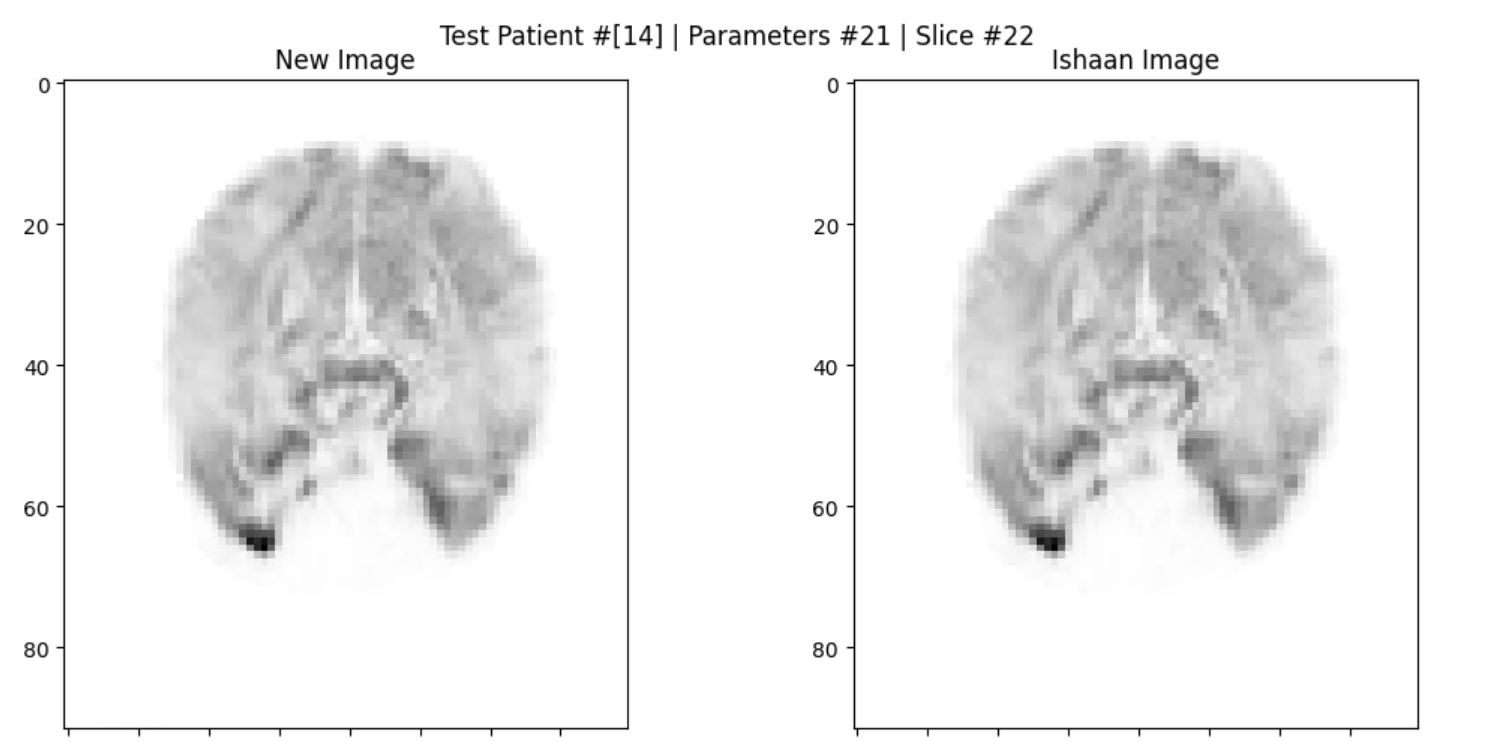